# Import the dataset

In [1]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

Data key corresponds to actual data, target key corresponds to data labels:

In [3]:
X, y = mnist['data'], mnist['target']

# Data exploration:

In [11]:
import numpy as np

In [4]:
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

In [18]:
np.unique(y,return_counts=True)

(array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object),
 array([6903, 7877, 6990, 7141, 6824, 6313, 6876, 7293, 6825, 6958],
       dtype=int64))

In [19]:
digit = X[0]

Each data instance is a 1 x 784 length vector, which corresponds to a 28 x 28 matrix:

In [20]:
digit_img = digit.reshape(28,28)

(-0.5, 27.5, 27.5, -0.5)

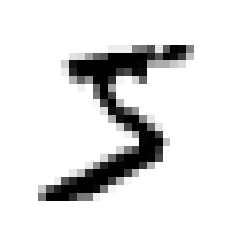

In [21]:
plt.imshow(digit_img,cmap='binary')
plt.axis('off')

In [22]:
y[0]

'5'

First instance in data set is a 5, as confirmed by the label. The label is a string, so we'll convert to an int:

In [23]:
y = y.astype(int)

# Create training and test set:

MNIST dataset is already split into a training set (first 60,000 images) and a test set (last 10,000 images):

In [24]:
X_train, X_test, y_train, y_test = X[:60000],X[60000:],y[:60000],y[60000:]

# Initial model testing:

In [64]:
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
import joblib

Try a Stochastic Gradient Descent (SGD) classifier first, which can do multiclass classification natively (i.e. does not require one vs one or one vs rest):

In [26]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Evaluate SGD Classifier's accuracy:

In [28]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring='accuracy')

array([0.8822 , 0.85885, 0.874  ])

Scaling the inputs to the SGD classifier boosts the accuracy to approximately 90%:

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_fl64 = X_train.astype(np.float64)
scaler.fit(X_train_fl64)
X_train_scaled = scaler.transform(X_train_fl64)

cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring='accuracy')

C:\Users\Development\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\Development\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.90095, 0.89915, 0.9061 ])

How does a RandomForestClassifier perform?

In [30]:
rand_forest_clf = RandomForestClassifier()
rand_forest_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
cross_val_score(rand_forest_clf, X_train,y_train,cv=3,scoring='accuracy')

array([0.9636 , 0.96245, 0.96605])

The RandomForestClassifier totally outperformed the SCGClassifier!

The kNearest Neighbors classifier showed the best performance however. The following GridSearch took about 6 hours to evaluate, hence it has been commented out.

In [32]:
'''
Following code was used to tune kNN classifier hyperparameters:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn_clf = KNeighborsClassifier()

param_grid = [
    {'weights':['uniform','distance'],'n_neighbors':[4,5,6]}
]

grid_search = GridSearchCV(knn_clf, param_grid, cv=3,scoring='accuracy',
                          return_train_score=False,verbose=3)
grid_search.fit(X_train, y_train)
grid_search.best_params_
knn_clf = grid_search.best_estimator_
joblib.dump(knn_clf,'models/mnist_knn_classifier_unscaled.pkl')
'''

"\nFollowing code was used to tune kNN classifier hyperparameters:\n\nfrom sklearn.neighbors import KNeighborsClassifier\nfrom sklearn.model_selection import GridSearchCV\n\nknn_clf = KNeighborsClassifier()\n\nparam_grid = [\n    {'weights':['uniform','distance'],'n_neighbors':[4,5,6]}\n]\n\ngrid_search = GridSearchCV(knn_clf, param_grid, cv=3,scoring='accuracy',\n                          return_train_score=False,verbose=3)\ngrid_search.fit(X_train, y_train)\ngrid_search.best_params_\nknn_clf = grid_search.best_estimator_\n"

The best parameters selected by the GridSearch were: n_neighbors = 4, weights = 'distance'. These are hard coded in the cell below:

In [33]:
knn_clf = KNeighborsClassifier(n_neighbors = 4, weights = 'distance')

In [34]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [35]:
cross_val_score(knn_clf, X_train,y_train,cv=3,scoring='accuracy')

array([0.9709 , 0.9698 , 0.97035])

# Error Analysis

In [37]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

The confusion matrix can be computed as follows:

In [38]:
cv_predictions = cross_val_predict(knn_clf, X_train,y_train,cv=3)

In [39]:
cfn_mx = confusion_matrix(y_train,cv_predictions)
cfn_mx

array([[5884,    3,    4,    0,    1,    4,   17,    1,    5,    4],
       [   1, 6706,   10,    1,    3,    1,    3,   10,    3,    4],
       [  41,   47, 5716,   18,   10,    5,    9,   83,   18,   11],
       [   7,   12,   29, 5891,    1,   72,    6,   38,   49,   26],
       [   3,   50,    1,    1, 5636,    0,   15,   16,    3,  117],
       [  15,    8,    4,   61,    6, 5218,   56,    6,   17,   30],
       [  21,   11,    1,    0,    7,   22, 5853,    0,    3,    0],
       [   3,   58,   12,    2,   11,    2,    0, 6109,    4,   64],
       [  17,   68,    8,   68,   29,   81,   26,   13, 5477,   64],
       [  13,    9,    5,   33,   51,   13,    5,   76,   13, 5731]],
      dtype=int64)

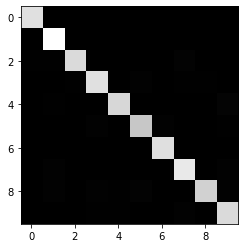

In [41]:
plt.imshow(cfn_mx, cmap=plt.cm.gray)

It's more helpful to look at the error matrix:

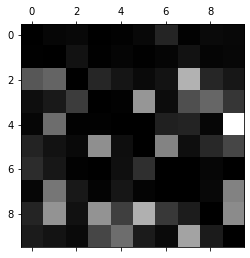

In [43]:
row_sums = cfn_mx.sum(axis=1, keepdims=True)
norm_conf_mx = cfn_mx / row_sums
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap = plt.cm.gray)

The lighter pixels correspond to a greater error. It can be seen that the classifier has a lot of trouble with 8s - it frequently mistakes them for another digit (the columns correspond to predicted classes, the rows correspong to actual labels or classes). Other errors in particular are 4s being mistaken for 9s, 2s being mistaken for 7s, and 7s being mistaken for 1s. These errors can be seen in the user app for this model - the model struggles to accurately predict 8s drawn on the turtle canvas.

# Improving the accuracy and final model selection:

In [44]:
from sklearn.metrics import accuracy_score

Is it possible to improve the accuracy beyond the 97% given by the kNN classifier or perhaps reduce some of the errors shown in the error matrix?

One solution is to try scale the inputs as done with the SGD classifier. The following cell took approximately 6 hours to run and is commented out for that reason:

In [45]:
'''
knn_clf_ex = KNeighborsClassifier()

param_grid = [
    {'weights':['uniform','distance'],'n_neighbors':[4,5,6]}
]

grid_search = GridSearchCV(knn_clf_ex, param_grid, cv=3,scoring='accuracy',
                          return_train_score=False,verbose=3)
grid_search.fit(X_train_scaled,y_train)
knn_scaled_model = grid_search.best_estimator_
joblib.dump(knn_model,'models/mnist_knn_classifier_scaled.pkl')
'''

"\nknn_clf_ex = KNeighborsClassifier()\n\nparam_grid = [\n    {'weights':['uniform','distance'],'n_neighbors':[4,5,6]}\n]\n\ngrid_search = GridSearchCV(knn_clf_ex, param_grid, cv=3,scoring='accuracy',\n                          return_train_score=False,verbose=3)\ngrid_search.fit(X_train_scaled,y_train)\nknn_model = grid_search.best_estimator_\njoblib.dump(knn_model,'models/mnist_knn_classifier_scaled.pkl')\n"

In [46]:
knn_scaled_model = KNeighborsClassifier(n_neighbors = 4, weights = 'distance')
knn_scaled_model.fit(X_train_scaled,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [47]:
X_test_prepared = scaler.transform(X_test.astype(np.float64))

In [48]:
y_test_pred = knn_scaled_model.predict(X_test_prepared)

accuracy_score(y_test, y_test_pred)

0.9489

Scaling the inputs actually reduced the accuracy to 95%.

The accuracy can also be improved by increasing the size of the training set. This can be done using data augmentation - altering elements in the existing dataset to produce new training instances. In this case, a function was designed to produce 4 copies of each image in the training set: 1 copy shifted up, 1 down, 1 left and 1 right.

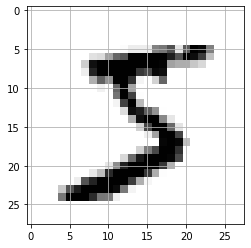

In [51]:
plt.imshow(digit_img, cmap='binary')
plt.axis('on')
plt.grid()

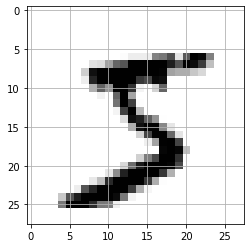

In [62]:
plt.imshow(np.roll(digit.reshape(28,28),1,axis=0),cmap='binary') # Shift the image 1 pixel down.
plt.axis('on')
plt.grid()

In [53]:
# 4 new images per existing training instance.

X_train_aug = np.zeros((len(X_train)*5,len(X_train[0])))
y_train_aug = np.zeros((len(y_train)*5,1))

In [54]:
X_train_aug.shape

(300000, 784)

In [55]:
X_train_aug[:60000,:] = X_train.copy()

In [56]:
y_train_aug[:60000,0] = y_train.copy()

In [63]:
def augment_image(img, idx, aug_matrix, aug_labels, img_label):
    '''
    Purpose of this function is to take in a 1x784 vector from the training set, reshape it to a 28x28
    matrix, and then create 4 copies - one shifted up, 1 down, 1 left and 1 right. These are appended to the end
    of the new, augmented training set, with their corresponding labels being appended to the labels vector.
    '''
    img_mx = img.reshape(28,28)
    for ax in [0,1]: # Sets shift axis to y and then x.
        for px in [-1,1]: # Shifts in both directions of y and x axis.
            aug_matrix[idx,:] = np.roll(img_mx,px,axis=ax).reshape(1,784)
            aug_labels[idx,0] = img_label
            idx+=1 # idx keeps track of the current index, so the new augmented images can be appended without any overlap.
    return idx

In [58]:
index = len(X_train) # First augmented image will be at index 60,000 (original X_train index goes from 0 - 59,999)

for datasets in zip(X_train, y_train):
    index = augment_image(datasets[0],index,X_train_aug, y_train_aug, datasets[1])

Cell below shuffles the augmented training set - as the function appends each augmented image sequentially i.e. the first 4 augmented images will all have the same label. Some algorithms are sensitive to the order of the data.

In [59]:
from sklearn.utils import shuffle

X_train_aug_shuffled, y_train_aug_shuffled = shuffle(X_train_aug, y_train_aug, random_state = 42)
y_train_aug_shuffled = y_train_aug_shuffled.ravel()

Train the kNN classifier on the new augmented training set:

In [60]:
knn_clf.fit(X_train_aug_shuffled, y_train_aug_shuffled)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [61]:
y_test_pred_aug = knn_clf.predict(X_test)

accuracy_score(y_test, y_test_pred_aug)

0.9763

Using data augmentation to increase the size of the training set increased the accuracy by 0.5%, giving a final accuracy on the test set of 97.63%. It's worth noting that it would've been best practice to evaluate the accuracy of the augmented training set and the scaled training set using cross validation before testing the final model on the test set as using the test set to select the best method may result in the model overfitting the test data.

Although the pickled file size is large (3 GB), this is the final model selected and used in the drawing app included in this repo.